In [1]:
!pip install pytorch_lightning 
!pip install scikit-learn
!pip install albumentations!pip install torch torchvision
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install opencv-python
!pip install scikit-learn
!pip install tqdm
!pip install pillow
!pip install efficientnet_pytorch
!pip install lightning

ERROR: Invalid requirement: 'albumentations!pip'


In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix
import sys
import lightning as L
from torch.optim.lr_scheduler import OneCycleLR

import pandas as pd
import seaborn as sns
import random
import shutil
import csv
from pathlib import Path

import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
def split_dataset(dataset_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    random.seed(seed)
    dataset_dir = Path(dataset_dir)
    output_dir = Path(output_dir)

    metadata = {
        'train': [],
        'val': [],
        'test': []
    }

    for split in ['train', 'val', 'test']:
        (output_dir / split).mkdir(parents=True, exist_ok=True)

    for class_dir in dataset_dir.iterdir():
        if class_dir.is_dir():
            images = list(class_dir.glob('*'))
            random.shuffle(images)

            n_total = len(images)
            n_train = int(n_total * train_ratio)
            n_val = int(n_total * val_ratio)

            splits = {
                'train': images[:n_train],
                'val': images[n_train:n_train + n_val],
                'test': images[n_train + n_val:]
            }

            for split, split_images in splits.items():
                split_class_dir = output_dir / split / class_dir.name
                split_class_dir.mkdir(parents=True, exist_ok=True)

                for img_path in split_images:
                    target_path = split_class_dir / img_path.name
                    shutil.copy(img_path, target_path)
                    metadata[split].append({
                        'filepath': str(target_path.relative_to(output_dir)),
                        'label': class_dir.name
                    })

    # Write metadata to CSV
    for split in ['train', 'val', 'test']:
        csv_path = output_dir / f'{split}.csv'
        with open(csv_path, mode='w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=['filepath', 'label'])
            writer.writeheader()
            writer.writerows(metadata[split])

    print(f"Dataset split and metadata CSVs saved to {output_dir}")

# split_dataset('./garbage_classification/garbage_classification', './splitted_dataset')

In [5]:
class GarbageDataset(Dataset):
    def __init__(self, csv_file, transform=None, classes=None, is_train=False):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = ''
        self.transform = transform
        self.is_train = is_train

        # Auto-detect classes if not provided
        if classes is None:
            classes = sorted(self.data_frame['label'].unique().tolist())

        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomRotation(degrees=15),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomErasing(p=0.2),
        ])

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Read path and label from CSV
        img_rel_path = self.data_frame.iloc[idx]['image_path'] 
        label_str = self.data_frame.iloc[idx]['label']

        # Convert label to index
        label_idx = torch.tensor(self.class_to_idx[label_str], dtype=torch.long)

        # Build absolute image path
        img_path = Path(self.img_dir) / img_rel_path

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.is_train:
            image = self.train_transforms(image)

        return image, label_idx


In [6]:
# Define common transforms
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Class names
classes = [
    'Glass', 'Hazardous Waste', 'Metal', 'Organic Waste', 'Paper & Cardboard', 'Plastic', 'Textiles', 'Trash'
]

In [7]:
"""
laod dataset
"""

# Create datasets and dataloaders
batch_size = 16

# Add initial data checking
print("Loading datasets...")
try:
    # Create datasets
    train_dataset = GarbageDataset(
        csv_file='./RGB_preprocessed_images/RGB_preprocessed_images/train.csv',
        transform=base_transform,
        classes=classes,
        is_train=True
    )
    img, label = train_dataset[0]
    print("Image path:", Path(train_dataset.img_dir) / train_dataset.data_frame.iloc[0]['image_path'])

    val_dataset = GarbageDataset(
        csv_file='./RGB_preprocessed_images/RGB_preprocessed_images/validation.csv',
        transform=base_transform,
        classes=classes,
        is_train=False
    )
    
    test_dataset = GarbageDataset(
        csv_file='.//RGB_preprocessed_images/RGB_preprocessed_images/test.csv',
        transform=base_transform,
        classes=classes,
        is_train=False
    )
    
    # Print a sample image filename to verify path construction
    sample_idx = 0
    img_name = train_dataset.data_frame.iloc[sample_idx, 0]
    img_path = img_name
    print(f"Sample image path: {img_path}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True,persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True,persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True,persistent_workers=True)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
except Exception as e:
    print(f"Error loading datasets: {e}")
    raise


Loading datasets...
Image path: RGB_preprocessed_images/RGB_preprocessed_images/train/Glass_0_processed.jpeg
Sample image path: RGB_preprocessed_images/RGB_preprocessed_images/train/Glass_0_processed.jpeg
Train dataset size: 12670
Validation dataset size: 1091
Test dataset size: 1090


In [8]:
"""
load ResNet Model
"""

# Initialize the ResNet152 model
resnet_model = models.resnet152(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 8) 

# Define the checkpoint file path (make sure you have the correct path)
resnet_checkpoint_path = 'models/resnet152_RGB.pth'

# Load the checkpoint
resnet_checkpoint = torch.load(resnet_checkpoint_path)

resnet_model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model.load_state_dict(resnet_checkpoint, strict=False)

print(resnet_model)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
"""
load DenseNet Model
"""
# Initialize DenseNet model (e.g., DenseNet121)
densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 8)

# Define the checkpoint file path (make sure this is your DenseNet checkpoint)
densenet_model_checkpoint_path = 'models/densenet121_RGB.pth'
densenet_model_checkpoint = torch.load(densenet_model_checkpoint_path)

densenet_model_state_dict = densenet_model.state_dict()

# Filter matching keys
densenet_model_filtered_dict = {k: v for k, v in densenet_model_checkpoint.items() if k in densenet_model_state_dict and v.shape == densenet_model_state_dict[k].shape}

# Update model with matched parameters
densenet_model_state_dict.update(densenet_model_filtered_dict)
densenet_model.load_state_dict(densenet_model_state_dict)

print(densenet_model)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
"""
load mobileNetV2 Model
"""
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

sys.modules['lightning'] = L
sys.modules['lightning.fabric'] = L.fabric

class MobileNetV2_6(L.LightningModule):

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained MobileNetV2 model
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),  # Increased dropout rate
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),  # SiLU/Swish activation (better than ReLU)
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def mixup_data(self, x, y):
        """Apply mixup augmentation to the batch."""
        if self.training and self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam
        else:
            return x, y, y, 1.0

    def forward(self, x):
        return self.model(x)

# Initialize model
mobilenet_model = MobileNetV2_6(n_classes=8)

# Load model weights from checkpoint (using the correct method to load only the model's weights)
mobilenet_checkpoint_path = 'models/mobilenetV2_RGB.pth'

# Load checkpoint (the model weights are stored as 'state_dict')
mobilenet_checkpoint = torch.load(mobilenet_checkpoint_path, map_location='cpu', weights_only=False)

# Make sure to load only the state_dict, not the entire model
if isinstance(mobilenet_checkpoint, dict):
    model_state_dict = mobilenet_model.state_dict()
    # Filter out keys that match the model's state_dict
    mobilenet_filtered_checkpoint = {k: v for k, v in mobilenet_checkpoint.items() if k in model_state_dict and v.shape == model_state_dict[k].shape}
    
    # Update the model's state_dict with the filtered checkpoint weights
    model_state_dict.update(mobilenet_filtered_checkpoint)
    
    # Load the updated state_dict into the model
    mobilenet_model.load_state_dict(model_state_dict)
else:
    print("The checkpoint is not in the expected format. Could not load state_dict.")

# Print the model summary
print(mobilenet_model)


The checkpoint is not in the expected format. Could not load state_dict.
MobileNetV2_6(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          

In [11]:
"""
load inceptionV3 Model
"""
from torchvision.models import (
    inception_v3, Inception_V3_Weights
)

# Assuming you have a PyTorch InceptionV3Optimized model class
class BaseGarbageClassifier(L.LightningModule):
    """Base class for all garbage classification models."""

    def __init__(self, n_classes, learning_rate=1e-3):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters for checkpointing
        self.save_hyperparameters()

    def forward(self, x):
        """Forward pass of the model. To be implemented by subclasses."""
        raise NotImplementedError("Subclasses must implement forward()")

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Log metrics
        self.log('test_accuracy', accuracy)
        self.log('test_precision', precision)
        self.log('test_recall', recall)
        self.log('test_f1', f1_score)
        self.log('test_auroc', auroc)

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Visualize Confusion Matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix_{self.__class__.__name__}.png")
        plt.show()

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def configure_optimizers(self):
        """Configure the optimizer and learning rate scheduler."""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4
        )

        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

class InceptionV3Optimized(BaseGarbageClassifier):
    def __init__(self, n_classes, learning_rate=3e-4):
        super().__init__(n_classes, learning_rate)

        # Load pretrained InceptionV3 model
        self.model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

        # Freeze most layers initially
        for param in self.model.parameters():
            param.requires_grad = False

        # Get input features dimension
        in_features = self.model.fc.in_features

        # Channel attention module (efficient version)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_features, in_features // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_features // 16, in_features, kernel_size=1),
            nn.Sigmoid()
        )

        # Replace final classifier with optimized version
        self.model.fc = nn.Sequential(
            nn.Dropout(0.35),  # More moderate dropout than Method 3
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # Swish activation (better than ReLU or LeakyReLU)
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Linear(512, n_classes)
        )

        # Replace auxiliary classifier (simpler than Method 3)
        if self.model.AuxLogits is not None:
            num_aux_features = self.model.AuxLogits.fc.in_features
            self.model.AuxLogits.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_aux_features, 512),
                nn.BatchNorm1d(512),
                nn.SiLU(),
                nn.Linear(512, n_classes)
            )

        # Progressive unfreezing - start with last blocks unfrozen
        for layer in [self.model.Mixed_7a, self.model.Mixed_7b, self.model.Mixed_7c]:
            for param in layer.parameters():
                param.requires_grad = True

        # Unfreeze classifier layers
        for param in self.model.fc.parameters():
            param.requires_grad = True

        if self.model.AuxLogits is not None:
            for param in self.model.AuxLogits.fc.parameters():
                param.requires_grad = True

        # Track unfreezing stage
        self.unfreeze_stage = 0

        # Mix of cross-entropy and label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Light label smoothing

        # Save hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Flag for test-time augmentation
        self.use_tta = True

    def forward(self, x):
        # Forward pass through the base model
        if self.training:
            # InceptionV3 returns (output, aux_output) during training
            output, aux_output = self.model(x)
            return output
        else:
            if self.use_tta:
                # Test-time augmentation (TTA)
                return self._test_time_augmentation(x)
            else:
                return self.model(x)

    def _test_time_augmentation(self, x):
        """Apply test-time augmentation for more robust predictions"""
        # Original prediction
        original_pred = self.model(x)

        # Horizontally flipped prediction
        x_flip = torch.flip(x, dims=[3])
        flip_pred = self.model(x_flip)

        # Average predictions
        return (original_pred + flip_pred) / 2.0

# Initialize your model
inception_model = InceptionV3Optimized(n_classes=8)

# Load only the model weights
inception_model_checkpoint_path = 'models/inceptionV3_RGB.pth'

# Load the checkpoint with weights_only=False
checkpoint = torch.load(inception_model_checkpoint_path, map_location='cpu', weights_only=False)

# Print the checkpoint type to inspect
print(f"Checkpoint Type: {type(checkpoint)}")

# If the checkpoint contains more than just the model state_dict
if isinstance(checkpoint, dict):
    print(f"Checkpoint keys: {checkpoint.keys()}")  # Check the structure of the checkpoint

    # Get the model's current state_dict
    inception_model_state_dict = inception_model.state_dict()

    # Now proceed with filtering matching keys as before
    inception_model_filtered_dict = {
        k: v for k, v in checkpoint.items() 
        if k in inception_model_state_dict and v.shape == inception_model_state_dict[k].shape
    }

    # Update the model with the matched parameters
    inception_model_state_dict.update(inception_model_filtered_dict)

    # Load the model weights into the initialized model
    inception_model.load_state_dict(inception_model_state_dict)

else:
    print("Checkpoint is not a dictionary, unable to load state_dict.")

# Print model summary
print(inception_model)

Checkpoint Type: <class '__main__.InceptionV3Optimized'>
Checkpoint is not a dictionary, unable to load state_dict.
InceptionV3Optimized(
  (criterion): CrossEntropyLoss()
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (test_precision): MulticlassPrecision()
  (test_recall): MulticlassRecall()
  (test_f1): MulticlassF1Score()
  (test_auroc): MulticlassAUROC()
  (test_confusion_matrix): MulticlassConfusionMatrix()
  (model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3

In [12]:
"""
Load EfficientNetV2 Model
"""
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

class EfficientNetV2MOptimized(L.LightningModule):

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained EfficientNetV2-M model
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for i in range(len(self.model.features)):
            for param in self.model.features[i].parameters():
                param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),  # Increased dropout rate
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # SiLU/Swish activation (better than ReLU)
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

# Create an instance of the custom EfficientNetV2 model with 8 output classes
efficientnet_model = EfficientNetV2MOptimized(n_classes=8)

# Define the checkpoint file path (make sure this is your EfficientNet checkpoint)
efficientnet_model_checkpoint_path = 'models/efficientnetv2_RGB.pth'

# Now load the model checkpoint
efficientnet_model_checkpoint = torch.load(efficientnet_model_checkpoint_path, map_location='cpu', weights_only=False)

# Get the model's state_dict
efficientnet_model_state_dict = efficientnet_model.state_dict()

# If the checkpoint is an actual model object, not a dictionary
efficientnet_model_checkpoint = efficientnet_model_checkpoint.state_dict()

# Now proceed with filtering matching keys as before
efficientnet_model_filtered_dict = {
    k: v for k, v in efficientnet_model_checkpoint.items() 
    if k in efficientnet_model_state_dict and v.shape == efficientnet_model_state_dict[k].shape
}

# Update the model with the matched parameters
efficientnet_model_state_dict.update(efficientnet_model_filtered_dict)
efficientnet_model.load_state_dict(efficientnet_model_state_dict)


# Print the model architecture
print(efficientnet_model)

EfficientNetV2MOptimized(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): B

Evaluating Ensemble on Random Samples:   0%|          | 0/20 [00:00<?, ?it/s]

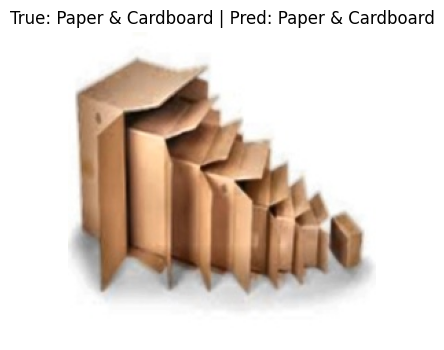

Evaluating Ensemble on Random Samples:   5%|▌         | 1/20 [00:00<00:03,  6.17it/s]

Image 1 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.44
  Hazardous Waste                     12.25
            Metal                     12.90
    Organic Waste                     12.28
Paper & Cardboard                     12.42
          Plastic                     12.65
         Textiles                     12.58
            Trash                     12.49
→ Model 1 Highest: Metal (12.90%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.71
  Hazardous Waste                     12.38
            Metal                     12.50
    Organic Waste                     12.55
Paper & Cardboard                     12.31
          Plastic                     12.92
         Textiles                     12.26
            Trash                     12.38
→ Model 2 Highest: Plastic (12.92%)
----------------------------------------
         

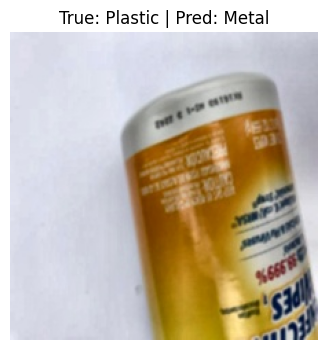

Evaluating Ensemble on Random Samples:  10%|█         | 2/20 [00:00<00:02,  6.22it/s]

Image 2 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.18
  Hazardous Waste                     13.01
            Metal                     12.82
    Organic Waste                     12.39
Paper & Cardboard                     12.00
          Plastic                     12.84
         Textiles                     12.29
            Trash                     12.46
→ Model 1 Highest: Hazardous Waste (13.01%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.76
  Hazardous Waste                     11.68
            Metal                     12.68
    Organic Waste                     13.45
Paper & Cardboard                     12.37
          Plastic                     12.73
         Textiles                     11.94
            Trash                     12.38
→ Model 2 Highest: Organic Waste (13.45%)
----------------------------------

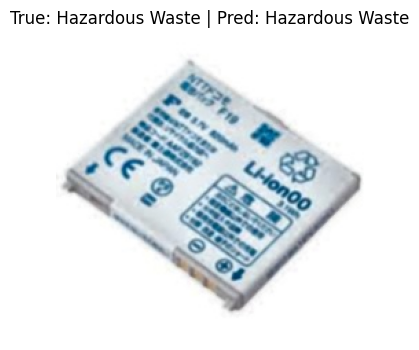

Evaluating Ensemble on Random Samples:  15%|█▌        | 3/20 [00:00<00:02,  6.47it/s]

Image 3 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     11.89
  Hazardous Waste                     12.73
            Metal                     12.56
    Organic Waste                     12.93
Paper & Cardboard                     12.35
          Plastic                     12.65
         Textiles                     12.31
            Trash                     12.58
→ Model 1 Highest: Organic Waste (12.93%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.88
  Hazardous Waste                     11.46
            Metal                     12.72
    Organic Waste                     13.21
Paper & Cardboard                     12.39
          Plastic                     12.21
         Textiles                     11.97
            Trash                     12.16
→ Model 2 Highest: Glass (13.88%)
----------------------------------------
   

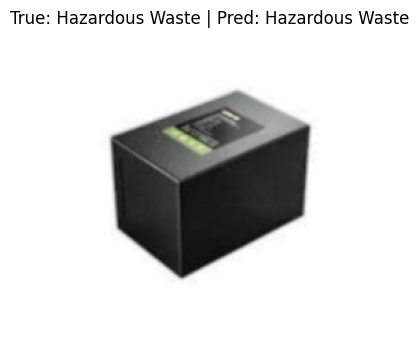

Evaluating Ensemble on Random Samples:  20%|██        | 4/20 [00:00<00:02,  6.79it/s]

Image 4 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.19
  Hazardous Waste                     13.05
            Metal                     12.81
    Organic Waste                     12.49
Paper & Cardboard                     12.17
          Plastic                     12.60
         Textiles                     12.12
            Trash                     12.56
→ Model 1 Highest: Hazardous Waste (13.05%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.63
  Hazardous Waste                     11.64
            Metal                     13.19
    Organic Waste                     12.96
Paper & Cardboard                     12.72
          Plastic                     12.34
         Textiles                     12.56
            Trash                     11.95
→ Model 2 Highest: Metal (13.19%)
----------------------------------------
 

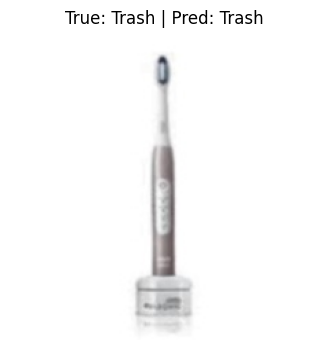

Evaluating Ensemble on Random Samples:  25%|██▌       | 5/20 [00:00<00:02,  7.11it/s]

Image 5 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     11.77
  Hazardous Waste                     12.66
            Metal                     12.54
    Organic Waste                     12.48
Paper & Cardboard                     12.57
          Plastic                     13.04
         Textiles                     12.76
            Trash                     12.19
→ Model 1 Highest: Plastic (13.04%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.94
  Hazardous Waste                     11.87
            Metal                     13.05
    Organic Waste                     12.89
Paper & Cardboard                     11.99
          Plastic                     12.56
         Textiles                     12.21
            Trash                     12.50
→ Model 2 Highest: Metal (13.05%)
----------------------------------------
         

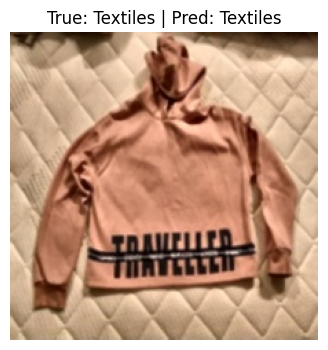

Evaluating Ensemble on Random Samples:  30%|███       | 6/20 [00:00<00:02,  6.63it/s]

Image 6 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     11.58
  Hazardous Waste                     12.88
            Metal                     12.89
    Organic Waste                     12.29
Paper & Cardboard                     12.29
          Plastic                     12.88
         Textiles                     12.79
            Trash                     12.40
→ Model 1 Highest: Metal (12.89%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.53
  Hazardous Waste                     11.73
            Metal                     12.68
    Organic Waste                     13.35
Paper & Cardboard                     11.51
          Plastic                     12.60
         Textiles                     12.62
            Trash                     11.98
→ Model 2 Highest: Glass (13.53%)
----------------------------------------
           

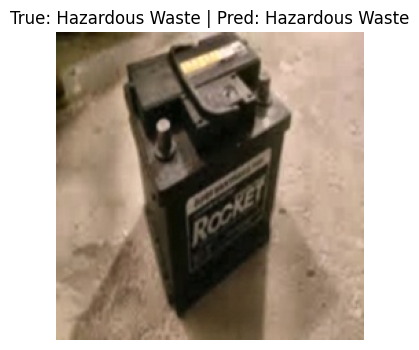

Evaluating Ensemble on Random Samples:  35%|███▌      | 7/20 [00:01<00:02,  6.43it/s]

Image 7 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.58
  Hazardous Waste                     13.47
            Metal                     12.32
    Organic Waste                     12.54
Paper & Cardboard                     11.66
          Plastic                     12.63
         Textiles                     12.19
            Trash                     12.61
→ Model 1 Highest: Hazardous Waste (13.47%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.56
  Hazardous Waste                     11.27
            Metal                     13.88
    Organic Waste                     13.30
Paper & Cardboard                     12.42
          Plastic                     11.94
         Textiles                     11.77
            Trash                     11.86
→ Model 2 Highest: Metal (13.88%)
----------------------------------------
 

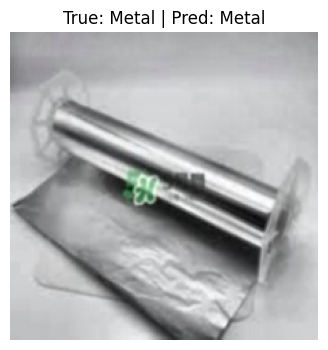

Evaluating Ensemble on Random Samples:  40%|████      | 8/20 [00:01<00:01,  6.47it/s]

Image 8 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.17
  Hazardous Waste                     12.92
            Metal                     12.72
    Organic Waste                     12.47
Paper & Cardboard                     12.05
          Plastic                     12.99
         Textiles                     12.34
            Trash                     12.35
→ Model 1 Highest: Plastic (12.99%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.72
  Hazardous Waste                     11.72
            Metal                     13.08
    Organic Waste                     12.86
Paper & Cardboard                     12.38
          Plastic                     12.59
         Textiles                     12.36
            Trash                     12.29
→ Model 2 Highest: Metal (13.08%)
----------------------------------------
         

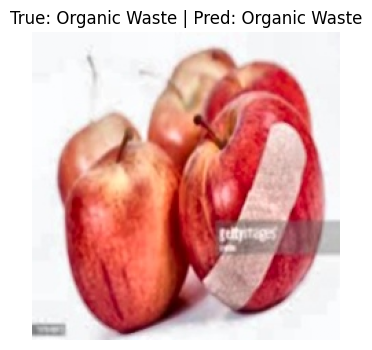

Evaluating Ensemble on Random Samples:  45%|████▌     | 9/20 [00:01<00:01,  6.23it/s]

Image 9 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.23
  Hazardous Waste                     13.26
            Metal                     12.82
    Organic Waste                     12.02
Paper & Cardboard                     12.29
          Plastic                     12.48
         Textiles                     12.42
            Trash                     12.49
→ Model 1 Highest: Hazardous Waste (13.26%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.19
  Hazardous Waste                     11.88
            Metal                     12.77
    Organic Waste                     13.08
Paper & Cardboard                     12.15
          Plastic                     12.24
         Textiles                     12.47
            Trash                     12.22
→ Model 2 Highest: Glass (13.19%)
----------------------------------------
 

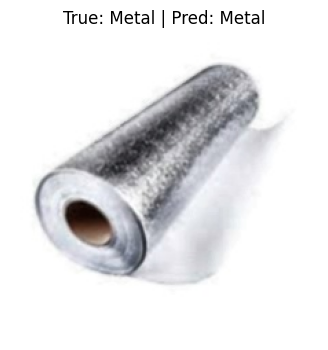

Evaluating Ensemble on Random Samples:  50%|█████     | 10/20 [00:01<00:01,  6.41it/s]

Image 10 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.21
  Hazardous Waste                     13.22
            Metal                     12.75
    Organic Waste                     12.46
Paper & Cardboard                     12.04
          Plastic                     12.84
         Textiles                     12.17
            Trash                     12.33
→ Model 1 Highest: Hazardous Waste (13.22%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.36
  Hazardous Waste                     11.71
            Metal                     12.92
    Organic Waste                     13.44
Paper & Cardboard                     11.95
          Plastic                     13.41
         Textiles                     11.75
            Trash                     12.46
→ Model 2 Highest: Organic Waste (13.44%)
---------------------------------

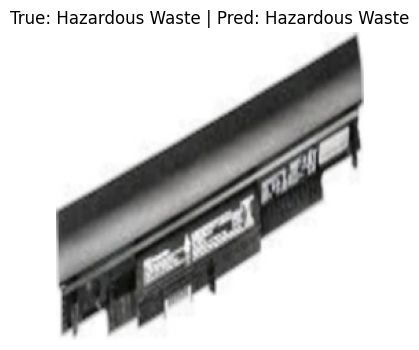

Evaluating Ensemble on Random Samples:  55%|█████▌    | 11/20 [00:01<00:01,  6.56it/s]

Image 11 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.33
  Hazardous Waste                     12.86
            Metal                     12.89
    Organic Waste                     12.21
Paper & Cardboard                     11.79
          Plastic                     13.25
         Textiles                     12.08
            Trash                     12.58
→ Model 1 Highest: Plastic (13.25%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.85
  Hazardous Waste                     12.09
            Metal                     12.83
    Organic Waste                     12.86
Paper & Cardboard                     12.26
          Plastic                     12.52
         Textiles                     12.43
            Trash                     12.16
→ Model 2 Highest: Organic Waste (12.86%)
----------------------------------------


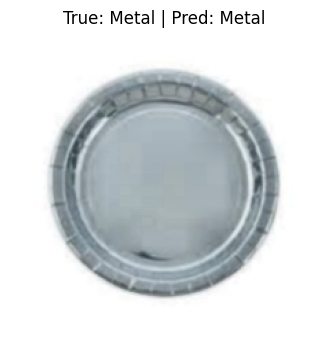

Evaluating Ensemble on Random Samples:  60%|██████    | 12/20 [00:01<00:01,  6.71it/s]

Image 12 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.31
  Hazardous Waste                     12.47
            Metal                     12.92
    Organic Waste                     12.44
Paper & Cardboard                     12.36
          Plastic                     12.79
         Textiles                     12.60
            Trash                     12.10
→ Model 1 Highest: Metal (12.92%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.66
  Hazardous Waste                     11.61
            Metal                     13.00
    Organic Waste                     12.80
Paper & Cardboard                     12.11
          Plastic                     12.88
         Textiles                     12.28
            Trash                     12.67
→ Model 2 Highest: Metal (13.00%)
----------------------------------------
          

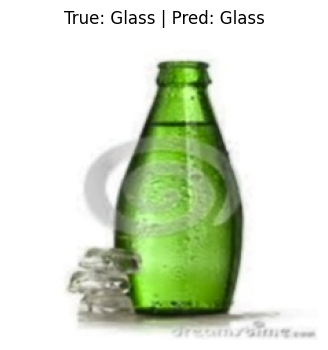

Evaluating Ensemble on Random Samples:  65%|██████▌   | 13/20 [00:01<00:01,  6.74it/s]

Image 13 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.07
  Hazardous Waste                     13.21
            Metal                     12.49
    Organic Waste                     12.11
Paper & Cardboard                     12.43
          Plastic                     12.58
         Textiles                     12.67
            Trash                     12.43
→ Model 1 Highest: Hazardous Waste (13.21%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.99
  Hazardous Waste                     11.90
            Metal                     12.98
    Organic Waste                     13.06
Paper & Cardboard                     11.76
          Plastic                     12.67
         Textiles                     12.48
            Trash                     12.14
→ Model 2 Highest: Organic Waste (13.06%)
---------------------------------

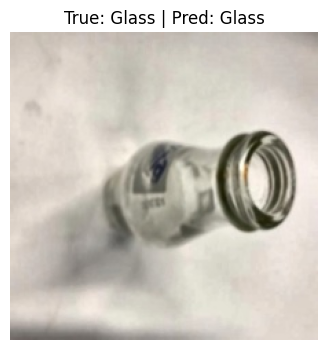

Evaluating Ensemble on Random Samples:  70%|███████   | 14/20 [00:02<00:00,  6.51it/s]

Image 14 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.13
  Hazardous Waste                     12.81
            Metal                     12.91
    Organic Waste                     12.08
Paper & Cardboard                     12.16
          Plastic                     12.99
         Textiles                     12.45
            Trash                     12.48
→ Model 1 Highest: Plastic (12.99%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.94
  Hazardous Waste                     12.02
            Metal                     12.90
    Organic Waste                     12.95
Paper & Cardboard                     12.02
          Plastic                     12.58
         Textiles                     12.15
            Trash                     12.44
→ Model 2 Highest: Organic Waste (12.95%)
----------------------------------------


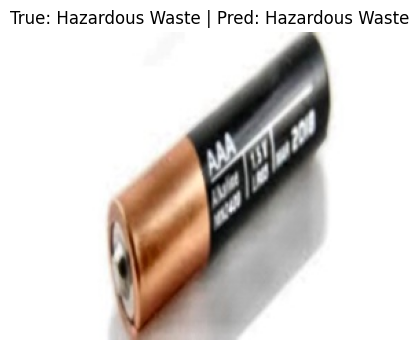

Evaluating Ensemble on Random Samples:  75%|███████▌  | 15/20 [00:02<00:00,  6.56it/s]

Image 15 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.14
  Hazardous Waste                     12.56
            Metal                     12.74
    Organic Waste                     12.48
Paper & Cardboard                     12.04
          Plastic                     12.67
         Textiles                     12.39
            Trash                     12.99
→ Model 1 Highest: Trash (12.99%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.17
  Hazardous Waste                     11.55
            Metal                     13.07
    Organic Waste                     12.51
Paper & Cardboard                     12.21
          Plastic                     13.11
         Textiles                     12.02
            Trash                     12.37
→ Model 2 Highest: Glass (13.17%)
----------------------------------------
          

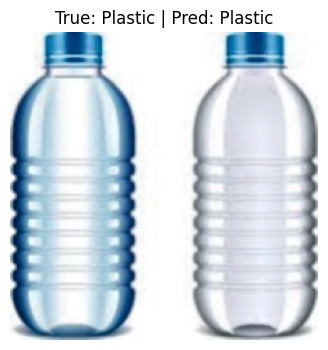

Evaluating Ensemble on Random Samples:  80%|████████  | 16/20 [00:02<00:00,  6.45it/s]

Image 16 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     11.74
  Hazardous Waste                     13.07
            Metal                     12.81
    Organic Waste                     12.44
Paper & Cardboard                     12.47
          Plastic                     12.71
         Textiles                     12.59
            Trash                     12.18
→ Model 1 Highest: Hazardous Waste (13.07%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.20
  Hazardous Waste                     11.46
            Metal                     12.91
    Organic Waste                     12.79
Paper & Cardboard                     12.01
          Plastic                     12.81
         Textiles                     12.23
            Trash                     12.58
→ Model 2 Highest: Glass (13.20%)
----------------------------------------


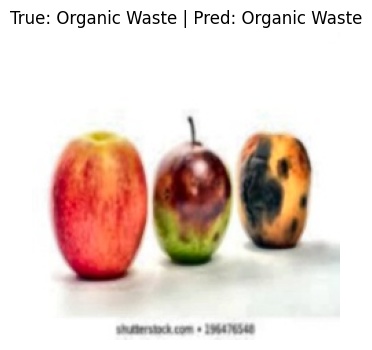

Evaluating Ensemble on Random Samples:  85%|████████▌ | 17/20 [00:02<00:00,  6.41it/s]

Image 17 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.16
  Hazardous Waste                     13.30
            Metal                     12.36
    Organic Waste                     12.38
Paper & Cardboard                     12.26
          Plastic                     12.53
         Textiles                     12.57
            Trash                     12.44
→ Model 1 Highest: Hazardous Waste (13.30%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.58
  Hazardous Waste                     11.71
            Metal                     13.04
    Organic Waste                     13.01
Paper & Cardboard                     12.45
          Plastic                     12.50
         Textiles                     12.21
            Trash                     12.49
→ Model 2 Highest: Metal (13.04%)
----------------------------------------


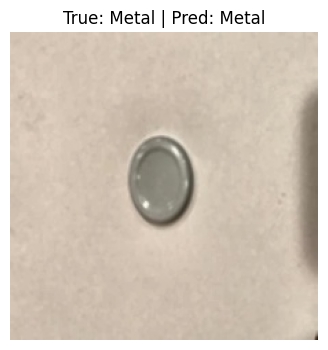

Evaluating Ensemble on Random Samples:  90%|█████████ | 18/20 [00:02<00:00,  6.50it/s]

Image 18 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.05
  Hazardous Waste                     13.02
            Metal                     12.44
    Organic Waste                     12.45
Paper & Cardboard                     12.40
          Plastic                     12.66
         Textiles                     12.41
            Trash                     12.56
→ Model 1 Highest: Hazardous Waste (13.02%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.43
  Hazardous Waste                     11.65
            Metal                     13.15
    Organic Waste                     12.18
Paper & Cardboard                     11.55
          Plastic                     12.48
         Textiles                     12.67
            Trash                     12.87
→ Model 2 Highest: Glass (13.43%)
----------------------------------------


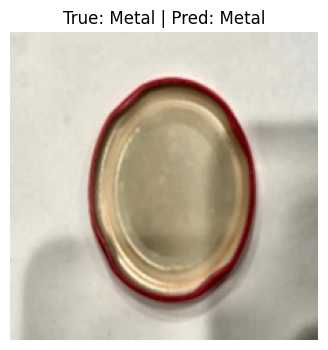

Evaluating Ensemble on Random Samples:  95%|█████████▌| 19/20 [00:02<00:00,  6.49it/s]

Image 19 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.28
  Hazardous Waste                     12.64
            Metal                     12.87
    Organic Waste                     12.37
Paper & Cardboard                     12.16
          Plastic                     12.61
         Textiles                     12.57
            Trash                     12.50
→ Model 1 Highest: Metal (12.87%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.01
  Hazardous Waste                     12.07
            Metal                     12.92
    Organic Waste                     13.05
Paper & Cardboard                     11.80
          Plastic                     12.38
         Textiles                     12.14
            Trash                     12.63
→ Model 2 Highest: Organic Waste (13.05%)
----------------------------------------
  

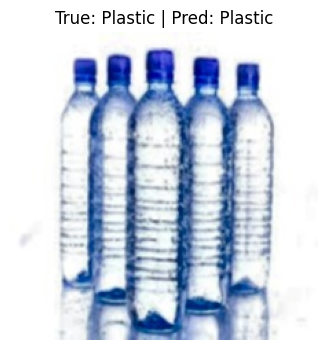

Evaluating Ensemble on Random Samples: 100%|██████████| 20/20 [00:03<00:00,  6.51it/s]

Image 20 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     11.97
  Hazardous Waste                     12.98
            Metal                     12.97
    Organic Waste                     12.28
Paper & Cardboard                     12.40
          Plastic                     12.92
         Textiles                     12.41
            Trash                     12.07
→ Model 1 Highest: Hazardous Waste (12.98%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.95
  Hazardous Waste                     11.87
            Metal                     12.30
    Organic Waste                     12.90
Paper & Cardboard                     12.30
          Plastic                     13.20
         Textiles                     12.26
            Trash                     12.23
→ Model 2 Highest: Plastic (13.20%)
---------------------------------------

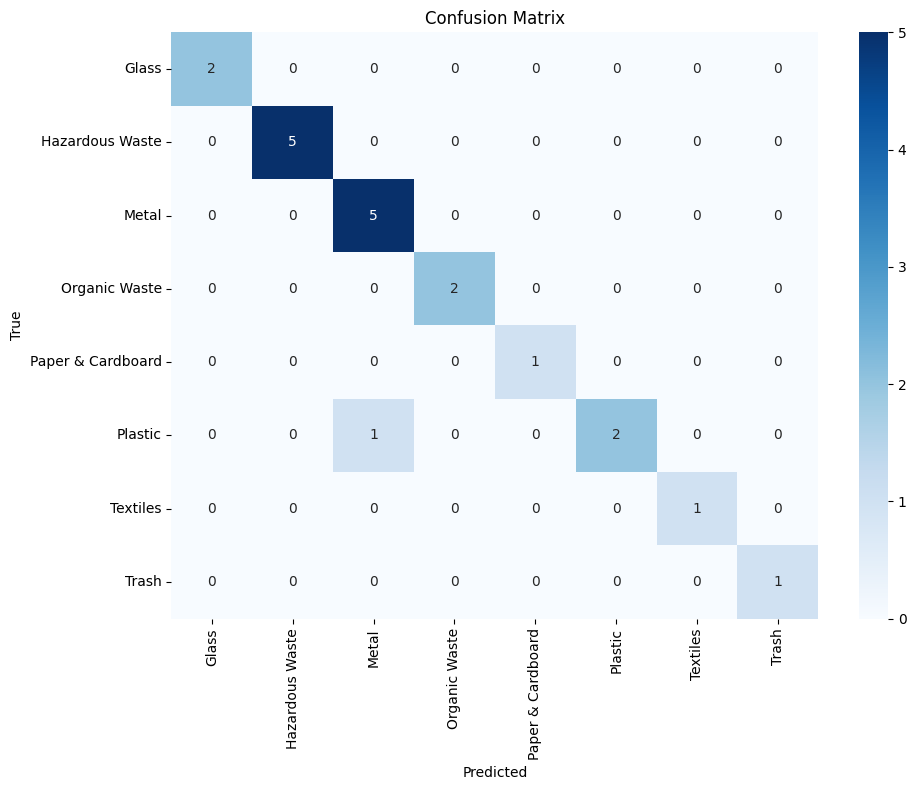


Summary:
Accuracy:  0.9500
Precision: 0.9583
Recall:    0.9500
F1 Score:  0.9473


In [16]:
"""
Run Ensemble Learning with Top 3 Models
"""

# === Ensemble Evaluation Function ===
def evaluate_ensemble_rgb(models, dataset, device, class_names, show_predictions=True, max_images_to_show=5):
    # Set all models to evaluation mode
    for model in models:
        model.eval()

    all_preds = []
    all_labels = []

    images_shown = 0

    model_names = ['mobilenet_model', 'inception_model', 'efficientnet_model']

    # Randomly sample max_images_to_show images from the dataset
    indices = random.sample(range(len(dataset)), max_images_to_show)

    with torch.no_grad():
        for idx in tqdm(indices, desc="Evaluating Ensemble on Random Samples"):
            image, label = dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            label_tensor = torch.tensor([label]).to(device)

            # Average softmax probabilities from all models
            avg_probs = torch.zeros((1, len(class_names))).to(device)
            all_model_probs = []  # Store each model's probabilities

            for model in models:
                outputs = model(image_input)
                probs = F.softmax(outputs, dim=1)
                avg_probs += probs
                all_model_probs.append(probs.cpu())

            avg_probs /= len(models)
            pred = torch.argmax(avg_probs, dim=1).item()

            all_preds.append(pred)
            all_labels.append(label)

            # === Show sample predictions ===
            if show_predictions:
                img = image.permute(1, 2, 0).cpu().numpy()
                true_label = class_names[label]
                pred_label = class_names[pred]

                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f"True: {true_label} | Pred: {pred_label}")
                plt.axis('off')
                plt.show()

                print(f"Image {images_shown+1} - Class Probabilities from Each Model:")
                for j, model_probs in enumerate(all_model_probs):
                    prob_row = model_probs[0]
                    probs_np = (prob_row.numpy() * 100).round(2)
                    top_idx = prob_row.argmax().item()
                    top_class = class_names[top_idx]
                    top_prob = probs_np[top_idx]

                    df = pd.DataFrame({
                        'Class': class_names,
                        f'{model_names[j]} Prob (%)': probs_np
                    })
                    print(df.to_string(index=False))
                    print(f"→ Model {j+1} Highest: {top_class} ({top_prob:.2f}%)")
                    print("-" * 40)
                print("\n" + "="*50 + "\n")

                images_shown += 1

    # === Evaluation Metrics ===
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds, target_names=class_names,
        labels=list(range(len(class_names))), zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1


# === Run ===

# Move all models to device
models = [mobilenet_model, inception_model, efficientnet_model]
for model in models:
    model.to(device)

# Evaluate the ensemble and show predictions
accuracy, precision, recall, f1 = evaluate_ensemble_rgb(
    models=models, 
    dataset=val_dataset, 
    device=device, 
    class_names=classes,
    show_predictions=True, 
    max_images_to_show=20
)

# Print summary
print(f"\nSummary:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Evaluating Ensemble on Full Dataset:   0%|          | 0/1091 [00:00<?, ?it/s]

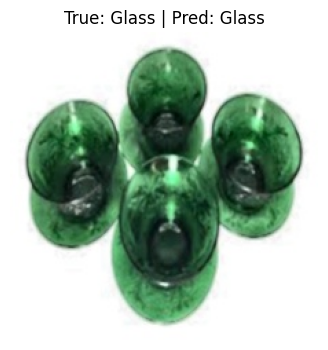

Evaluating Ensemble on Full Dataset:   0%|          | 1/1091 [00:00<10:03,  1.81it/s]

Image 1 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.37
  Hazardous Waste                     12.99
            Metal                     12.72
    Organic Waste                     12.18
Paper & Cardboard                     11.99
          Plastic                     12.87
         Textiles                     12.82
            Trash                     12.07
→ Model 1 Highest: Hazardous Waste (12.99%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     12.53
  Hazardous Waste                     12.28
            Metal                     12.49
    Organic Waste                     12.98
Paper & Cardboard                     12.05
          Plastic                     12.84
         Textiles                     12.59
            Trash                     12.24
→ Model 2 Highest: Organic Waste (12.98%)
----------------------------------

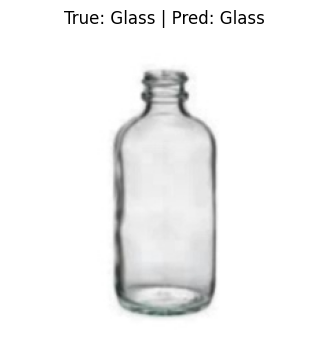

Evaluating Ensemble on Full Dataset:   0%|          | 2/1091 [00:00<05:35,  3.25it/s]

Image 2 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.22
  Hazardous Waste                     12.98
            Metal                     12.89
    Organic Waste                     12.35
Paper & Cardboard                     12.17
          Plastic                     12.62
         Textiles                     12.57
            Trash                     12.20
→ Model 1 Highest: Hazardous Waste (12.98%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.14
  Hazardous Waste                     12.15
            Metal                     12.05
    Organic Waste                     13.14
Paper & Cardboard                     11.76
          Plastic                     12.87
         Textiles                     12.35
            Trash                     12.55
→ Model 2 Highest: Organic Waste (13.14%)
----------------------------------

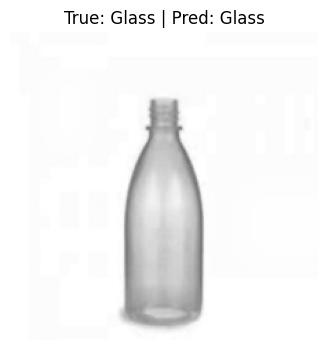

Evaluating Ensemble on Full Dataset:   0%|          | 3/1091 [00:00<04:09,  4.37it/s]

Image 3 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.29
  Hazardous Waste                     12.98
            Metal                     12.68
    Organic Waste                     12.31
Paper & Cardboard                     12.32
          Plastic                     12.71
         Textiles                     12.56
            Trash                     12.15
→ Model 1 Highest: Hazardous Waste (12.98%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.09
  Hazardous Waste                     12.00
            Metal                     12.84
    Organic Waste                     13.24
Paper & Cardboard                     11.95
          Plastic                     12.23
         Textiles                     12.53
            Trash                     12.13
→ Model 2 Highest: Organic Waste (13.24%)
----------------------------------

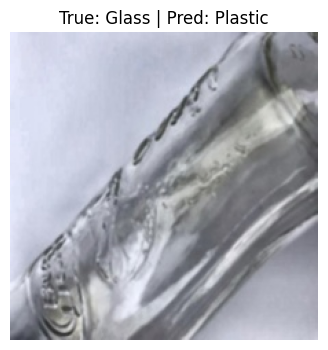

Evaluating Ensemble on Full Dataset:   0%|          | 4/1091 [00:00<03:38,  4.98it/s]

Image 4 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.16
  Hazardous Waste                     12.89
            Metal                     12.66
    Organic Waste                     12.18
Paper & Cardboard                     12.33
          Plastic                     13.17
         Textiles                     12.29
            Trash                     12.32
→ Model 1 Highest: Plastic (13.17%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.28
  Hazardous Waste                     11.54
            Metal                     13.07
    Organic Waste                     13.24
Paper & Cardboard                     11.94
          Plastic                     12.79
         Textiles                     12.10
            Trash                     12.04
→ Model 2 Highest: Glass (13.28%)
----------------------------------------
         

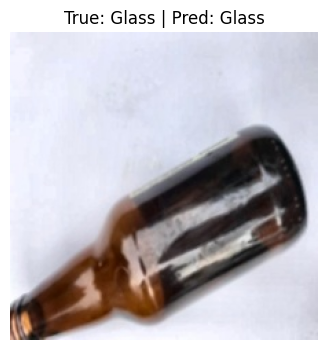

Evaluating Ensemble on Full Dataset:   0%|          | 5/1091 [00:01<03:22,  5.37it/s]

Image 5 - Class Probabilities from Each Model:
            Class  mobilenet_model Prob (%)
            Glass                     12.48
  Hazardous Waste                     12.92
            Metal                     12.42
    Organic Waste                     12.40
Paper & Cardboard                     12.27
          Plastic                     12.94
         Textiles                     12.27
            Trash                     12.31
→ Model 1 Highest: Plastic (12.94%)
----------------------------------------
            Class  inception_model Prob (%)
            Glass                     13.12
  Hazardous Waste                     11.86
            Metal                     13.09
    Organic Waste                     13.15
Paper & Cardboard                     11.72
          Plastic                     12.81
         Textiles                     12.06
            Trash                     12.20
→ Model 2 Highest: Organic Waste (13.15%)
----------------------------------------
 

Evaluating Ensemble on Full Dataset: 100%|██████████| 1091/1091 [01:14<00:00, 14.61it/s]



Classification Report:
                   precision    recall  f1-score   support

            Glass       0.95      0.93      0.94       150
  Hazardous Waste       0.96      0.99      0.97       142
            Metal       0.87      0.94      0.90       116
    Organic Waste       0.97      0.99      0.98       148
Paper & Cardboard       0.94      0.97      0.95       150
          Plastic       0.97      0.88      0.92       130
         Textiles       0.99      0.96      0.98       150
            Trash       0.99      0.95      0.97       105

         accuracy                           0.95      1091
        macro avg       0.95      0.95      0.95      1091
     weighted avg       0.95      0.95      0.95      1091



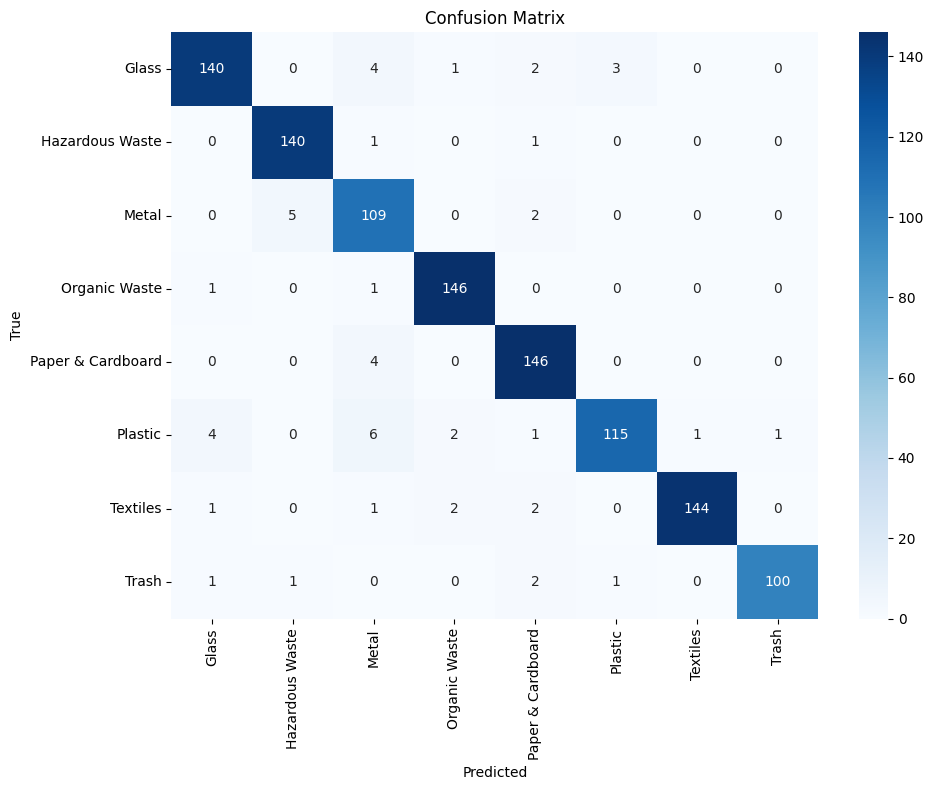


Summary:
Accuracy:  0.9533
Precision: 0.9545
Recall:    0.9533
F1 Score:  0.9533


In [17]:
import random

"""
Ensemble learning on Top 3 models
"""

# === Ensemble Evaluation Function ===
def evaluate_ensemble_rgb(models, dataset, device, class_names, show_predictions=True, max_images_to_show=5):
    # Set all models to evaluation mode
    for model in models:
        model.eval()

    all_preds = []
    all_labels = []
    images_shown = 0
    model_names = ['mobilenet_model', 'inception_model', 'efficientnet_model']

    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc="Evaluating Ensemble on Full Dataset"):
            image, label = dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            label_tensor = torch.tensor([label]).to(device)

            # Average softmax probabilities from all models
            avg_probs = torch.zeros((1, len(class_names))).to(device)
            all_model_probs = []  # Store each model's probabilities

            for model in models:
                outputs = model(image_input)
                probs = F.softmax(outputs, dim=1)
                avg_probs += probs
                all_model_probs.append(probs.cpu())

            avg_probs /= len(models)
            pred = torch.argmax(avg_probs, dim=1).item()

            all_preds.append(pred)
            all_labels.append(label)

            # === Show sample predictions ===
            if show_predictions and images_shown < max_images_to_show:
                img = image.permute(1, 2, 0).cpu().numpy()
                true_label = class_names[label]
                pred_label = class_names[pred]

                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f"True: {true_label} | Pred: {pred_label}")
                plt.axis('off')
                plt.show()

                print(f"Image {images_shown+1} - Class Probabilities from Each Model:")
                for j, model_probs in enumerate(all_model_probs):
                    prob_row = model_probs[0]
                    probs_np = (prob_row.numpy() * 100).round(2)
                    top_idx = prob_row.argmax().item()
                    top_class = class_names[top_idx]
                    top_prob = probs_np[top_idx]

                    df = pd.DataFrame({
                        'Class': class_names,
                        f'{model_names[j]} Prob (%)': probs_np
                    })
                    print(df.to_string(index=False))
                    print(f"→ Model {j+1} Highest: {top_class} ({top_prob:.2f}%)")
                    print("-" * 40)
                print("\n" + "="*50 + "\n")

                images_shown += 1

    # === Evaluation Metrics ===
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds, target_names=class_names,
        labels=list(range(len(class_names))), zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1


# === Run ===

# Move all models to device
models = [mobilenet_model, inception_model, efficientnet_model]
for model in models:
    model.to(device)

# Evaluate the ensemble and show predictions
accuracy, precision, recall, f1 = evaluate_ensemble_rgb(
    models=models, 
    dataset=val_dataset, 
    device=device, 
    class_names=classes,
    show_predictions=True, 
    max_images_to_show=5
)

# Print summary
print(f"\nSummary:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
